# LAB 1
- Adrian Fulladolsa
- Renatto Guzmán

## Ejercicio 1
Implementar en Python una funci´on que haga la ecualizaci´on de histograma para una imagen en escala de grises (8 bits).
Mostrar a trav´es de ejemplos la imagen original y la imagen ecualizada. Mostrar tambi´en los histogramas normalizados y su
distribuci´on acumulada de ambas im´agenes.
Comparar los resultados de su funci´on contra alguna funci´on ya predefinida en Python para calcular ecualizaciones. Por
ejemplo, en scikit-image, tenemos la funci´on skimage.exposure.equalize hist; o en OpenCV, tenemos la funci´on
cv2.equalizeHist.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, exposure
import cv2

In [4]:
def custom_histogram_equalization(image):
    """
    Implementa la ecualización de histograma para una imagen en escala de grises.

    Args:
        image: Imagen en escala de grises (numpy array)

    Returns:
        imagen_ecualizada: Imagen después de la ecualización del histograma
    """
    if image.dtype != np.uint8:
        raise ValueError("La imagen debe ser uint8")

    # Calcular el histograma
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])

    # Calcular la distribución acumulada normalizada
    cdf = hist.cumsum()
    cdf_normalizado = ((cdf - cdf.min()) * 255) / (cdf.max() - cdf.min())
    cdf_normalizado = cdf_normalizado.astype(np.uint8)

    # Aplicar la transformación a la imagen
    imagen_ecualizada = cdf_normalizado[image]

    return imagen_ecualizada

In [5]:
def plot_results(imagen_original, titulo="Comparación de Ecualizaciones"):
    """
    Visualiza la imagen original, ecualizadas y sus histogramas.
    """
    # Aplicar las diferentes ecualizaciones
    eq_custom = custom_histogram_equalization(imagen_original)
    eq_skimage = (exposure.equalize_hist(imagen_original) * 255).astype(np.uint8)
    eq_opencv = cv2.equalizeHist(imagen_original)

    # Crear la figura para mostrar los resultados
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    fig.suptitle(titulo, fontsize=16)

    # Lista de imágenes y sus títulos
    imagenes = [imagen_original, eq_custom, eq_skimage, eq_opencv]
    titulos = ['Original', 'Ecualización Custom', 'Ecualización Scikit-image', 'Ecualización OpenCV']

    for idx, (img, title) in enumerate(zip(imagenes, titulos)):
        # Mostrar imagen
        axes[idx, 0].imshow(img, cmap='gray')
        axes[idx, 0].set_title(f'{title}')
        axes[idx, 0].axis('off')

        # Mostrar histograma
        hist, bins = np.histogram(img.flatten(), 256, [0, 256])
        hist_norm = hist / hist.sum()  # Normalizar histograma
        axes[idx, 1].bar(bins[:-1], hist_norm, width=1)
        axes[idx, 1].set_title(f'Histograma {title}')
        axes[idx, 1].set_xlim([0, 256])

        # Mostrar CDF
        cdf = hist_norm.cumsum()
        axes[idx, 2].plot(bins[:-1], cdf)
        axes[idx, 2].set_title(f'CDF {title}')
        axes[idx, 2].set_xlim([0, 256])
        axes[idx, 2].grid(True)

    plt.tight_layout()
    plt.show()

In [7]:
def equilize_and_plot_image(image):
    imagen = io.imread(image, as_gray=True)
    imagen = (imagen * 255).astype(np.uint8)  # Convertir a uint8

    # Mostrar resultados
    plot_results(imagen)

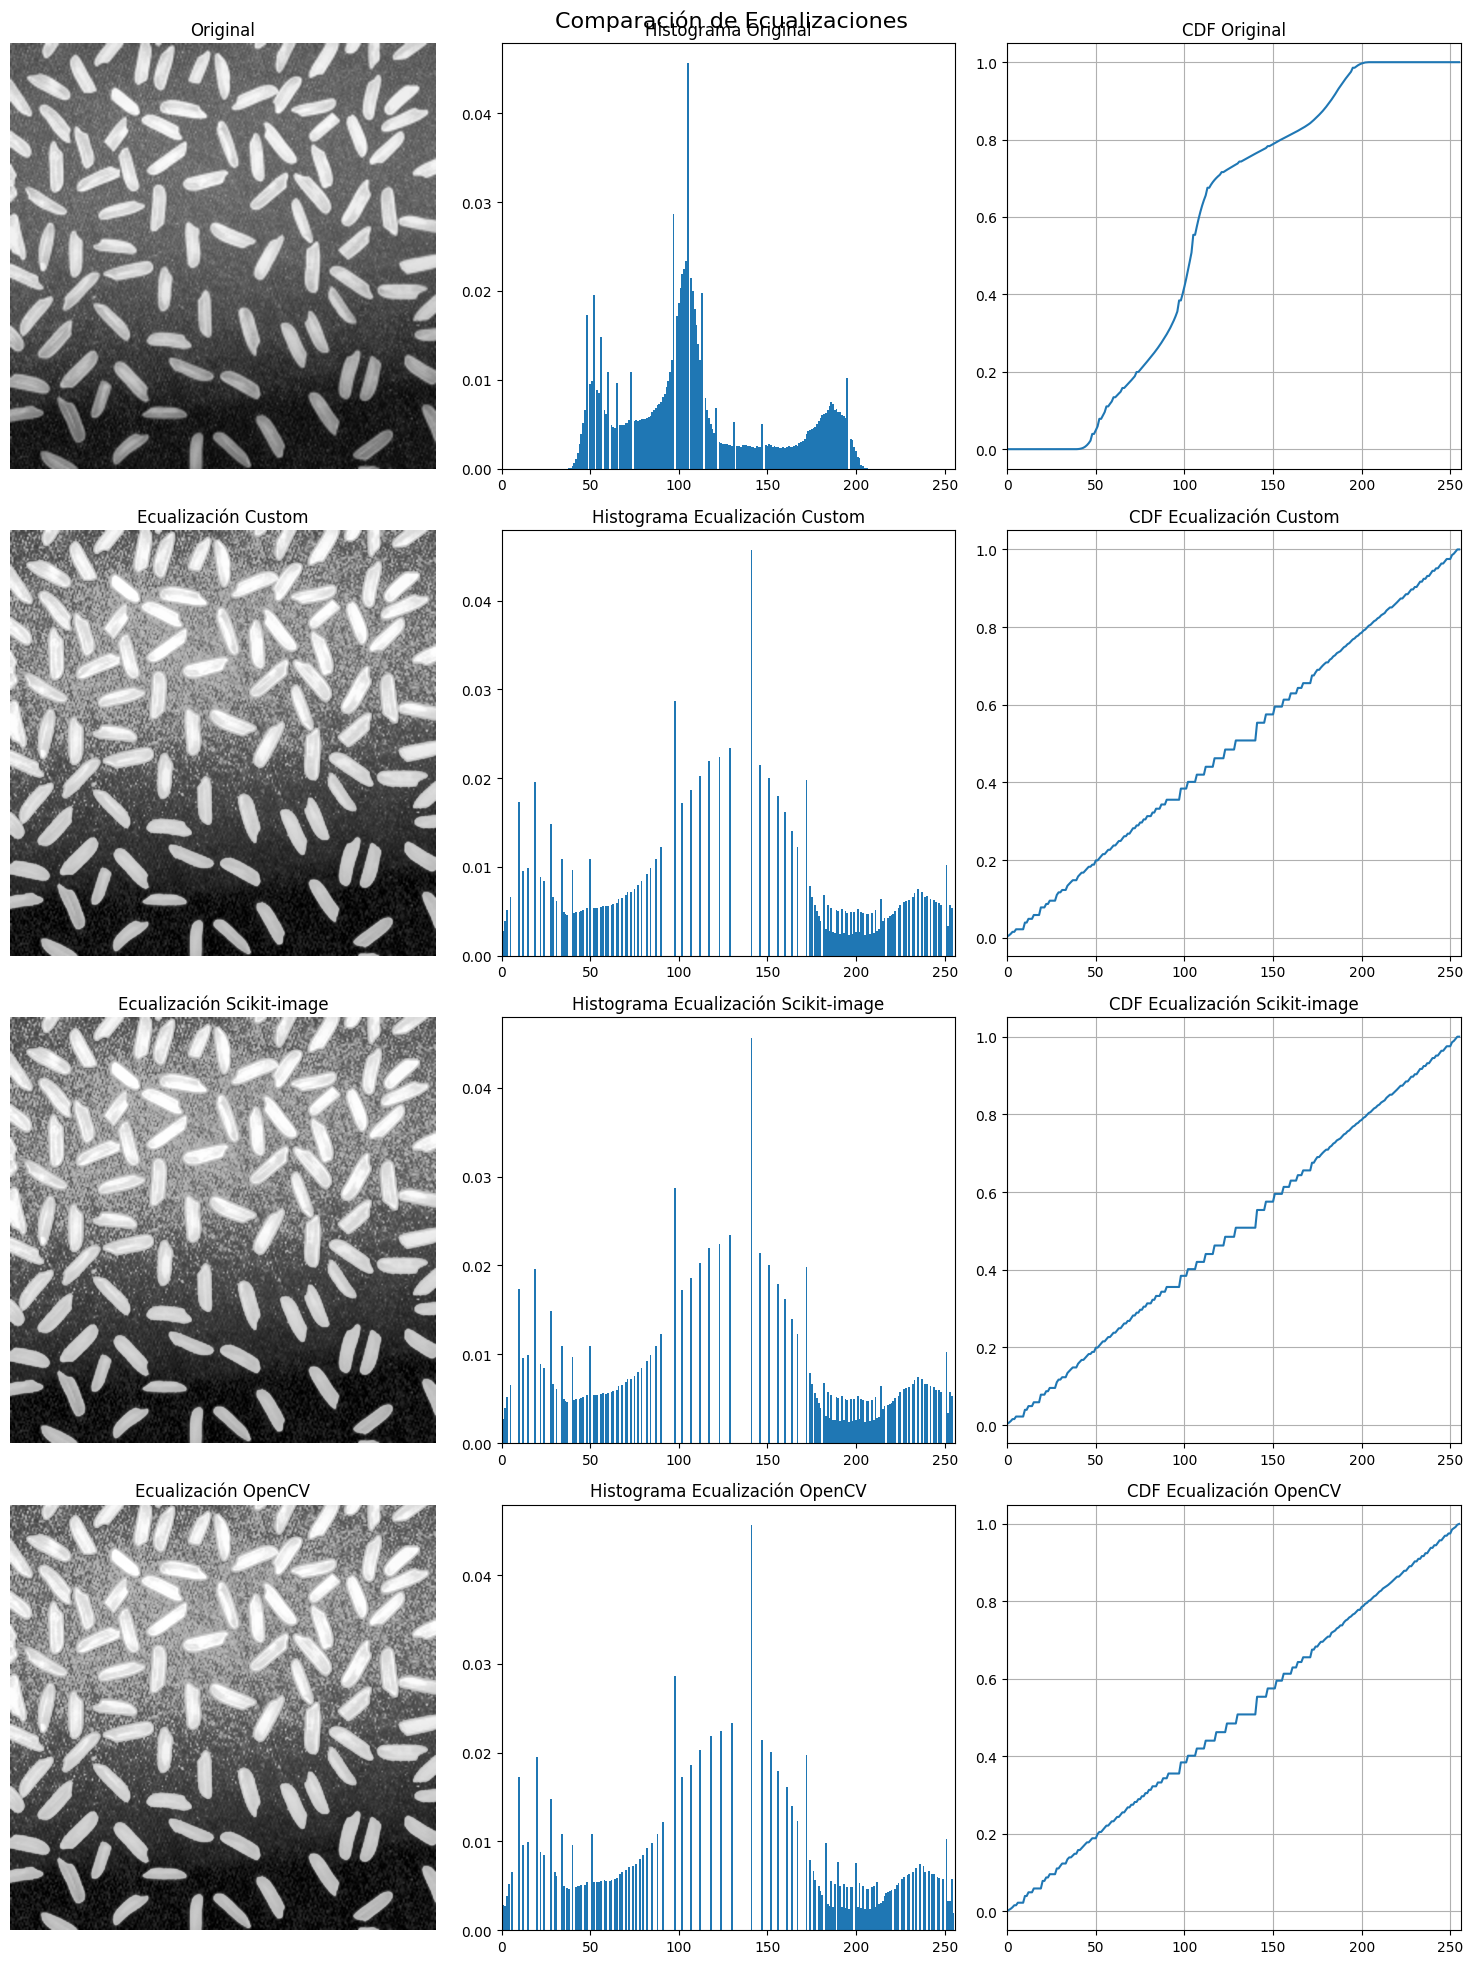

In [8]:
equilize_and_plot_image("./res/rice.jpg")

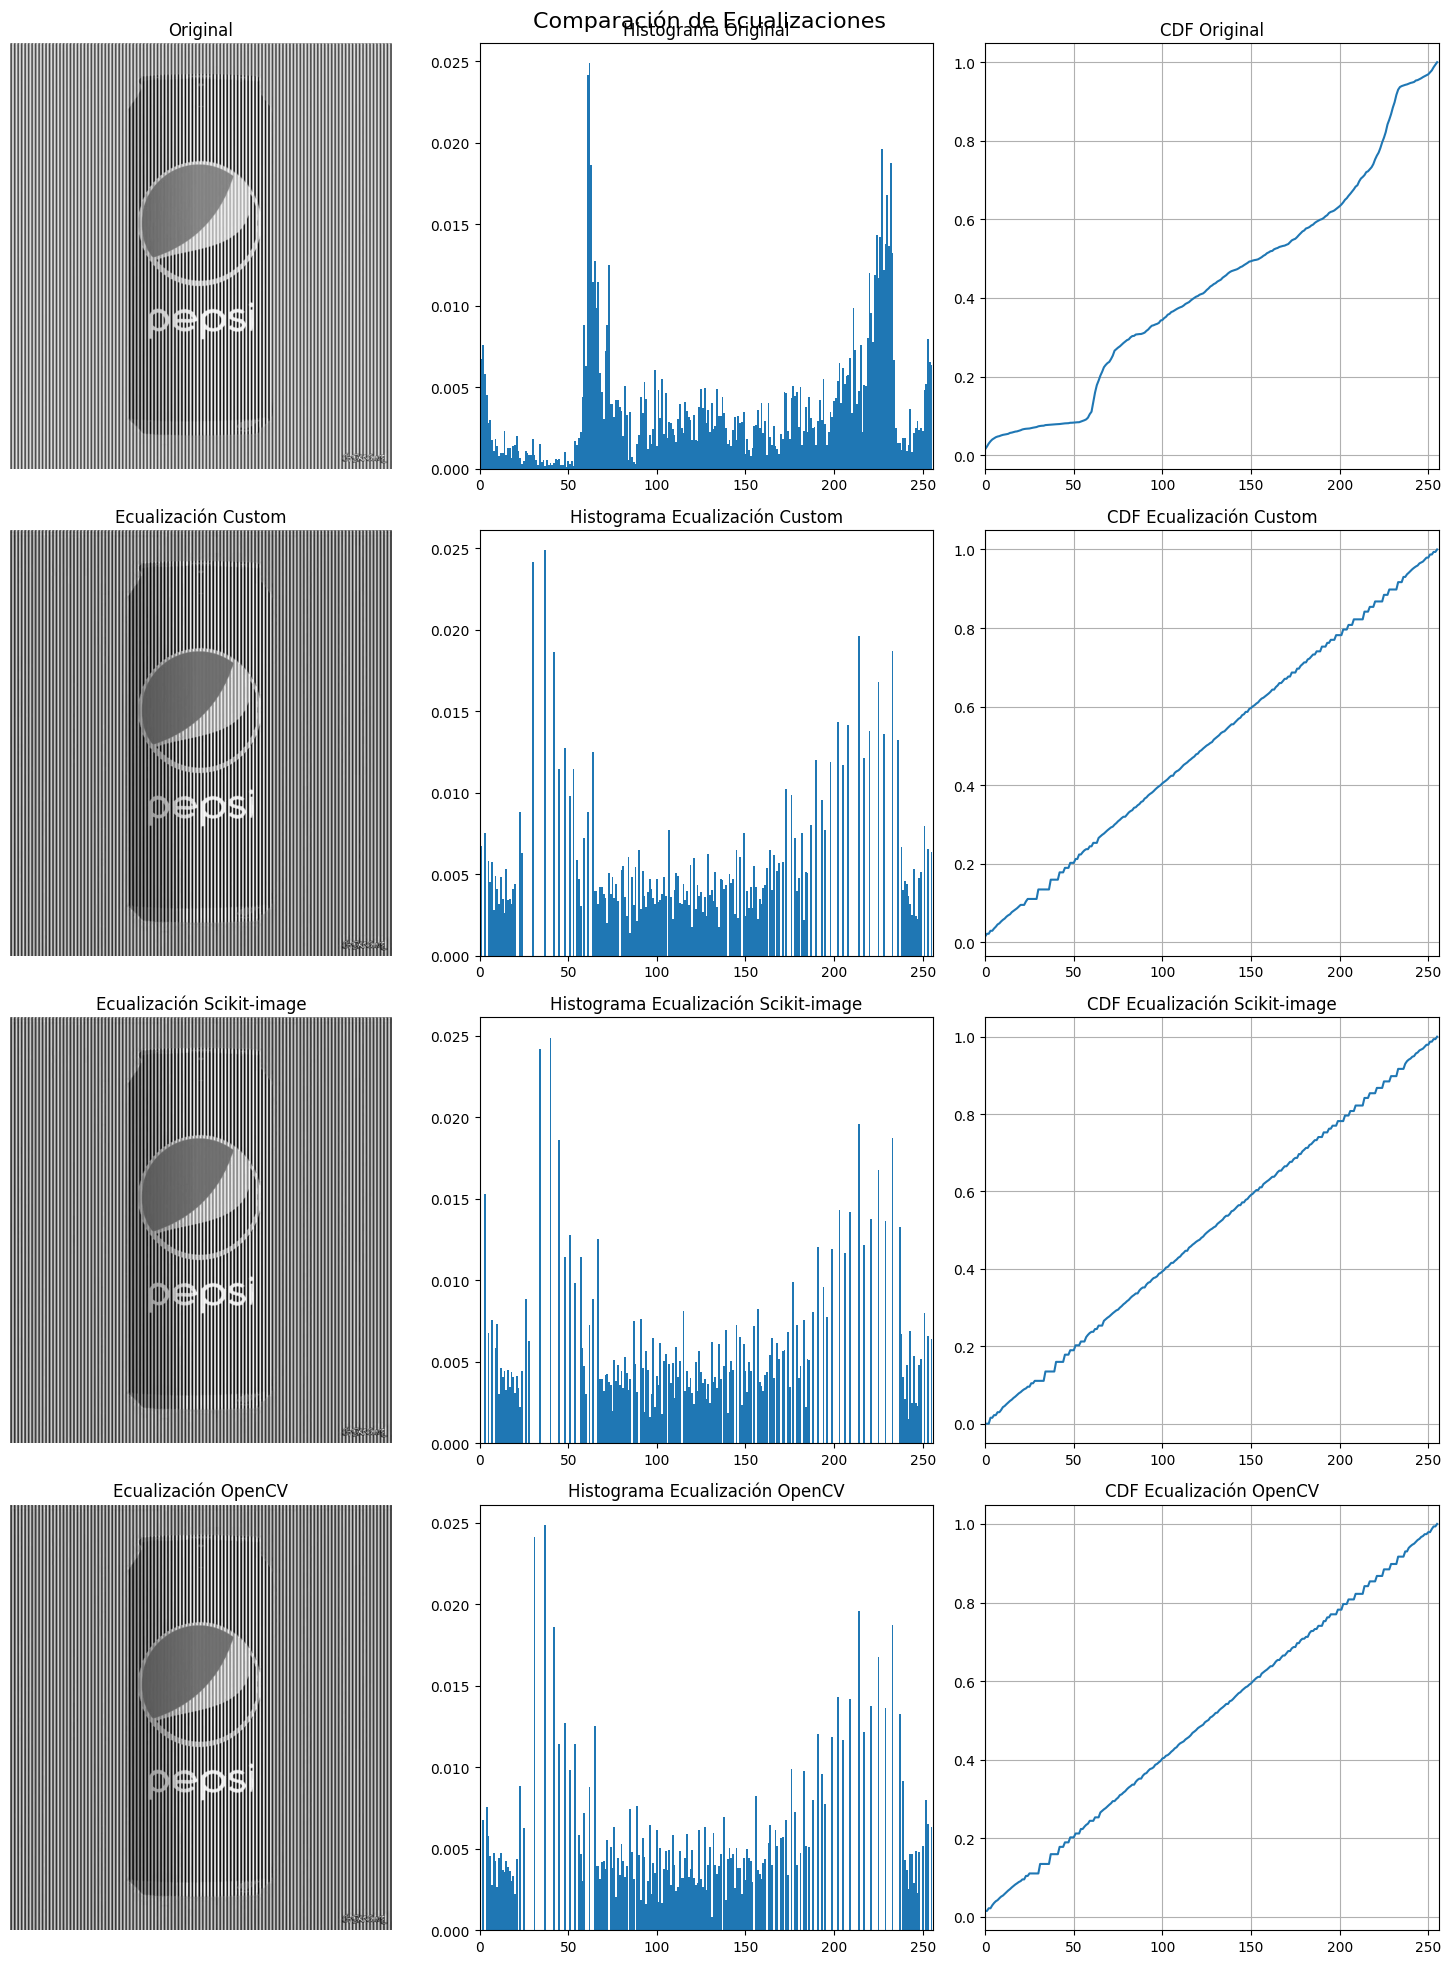

In [9]:
equilize_and_plot_image("./res/pepsi.png")

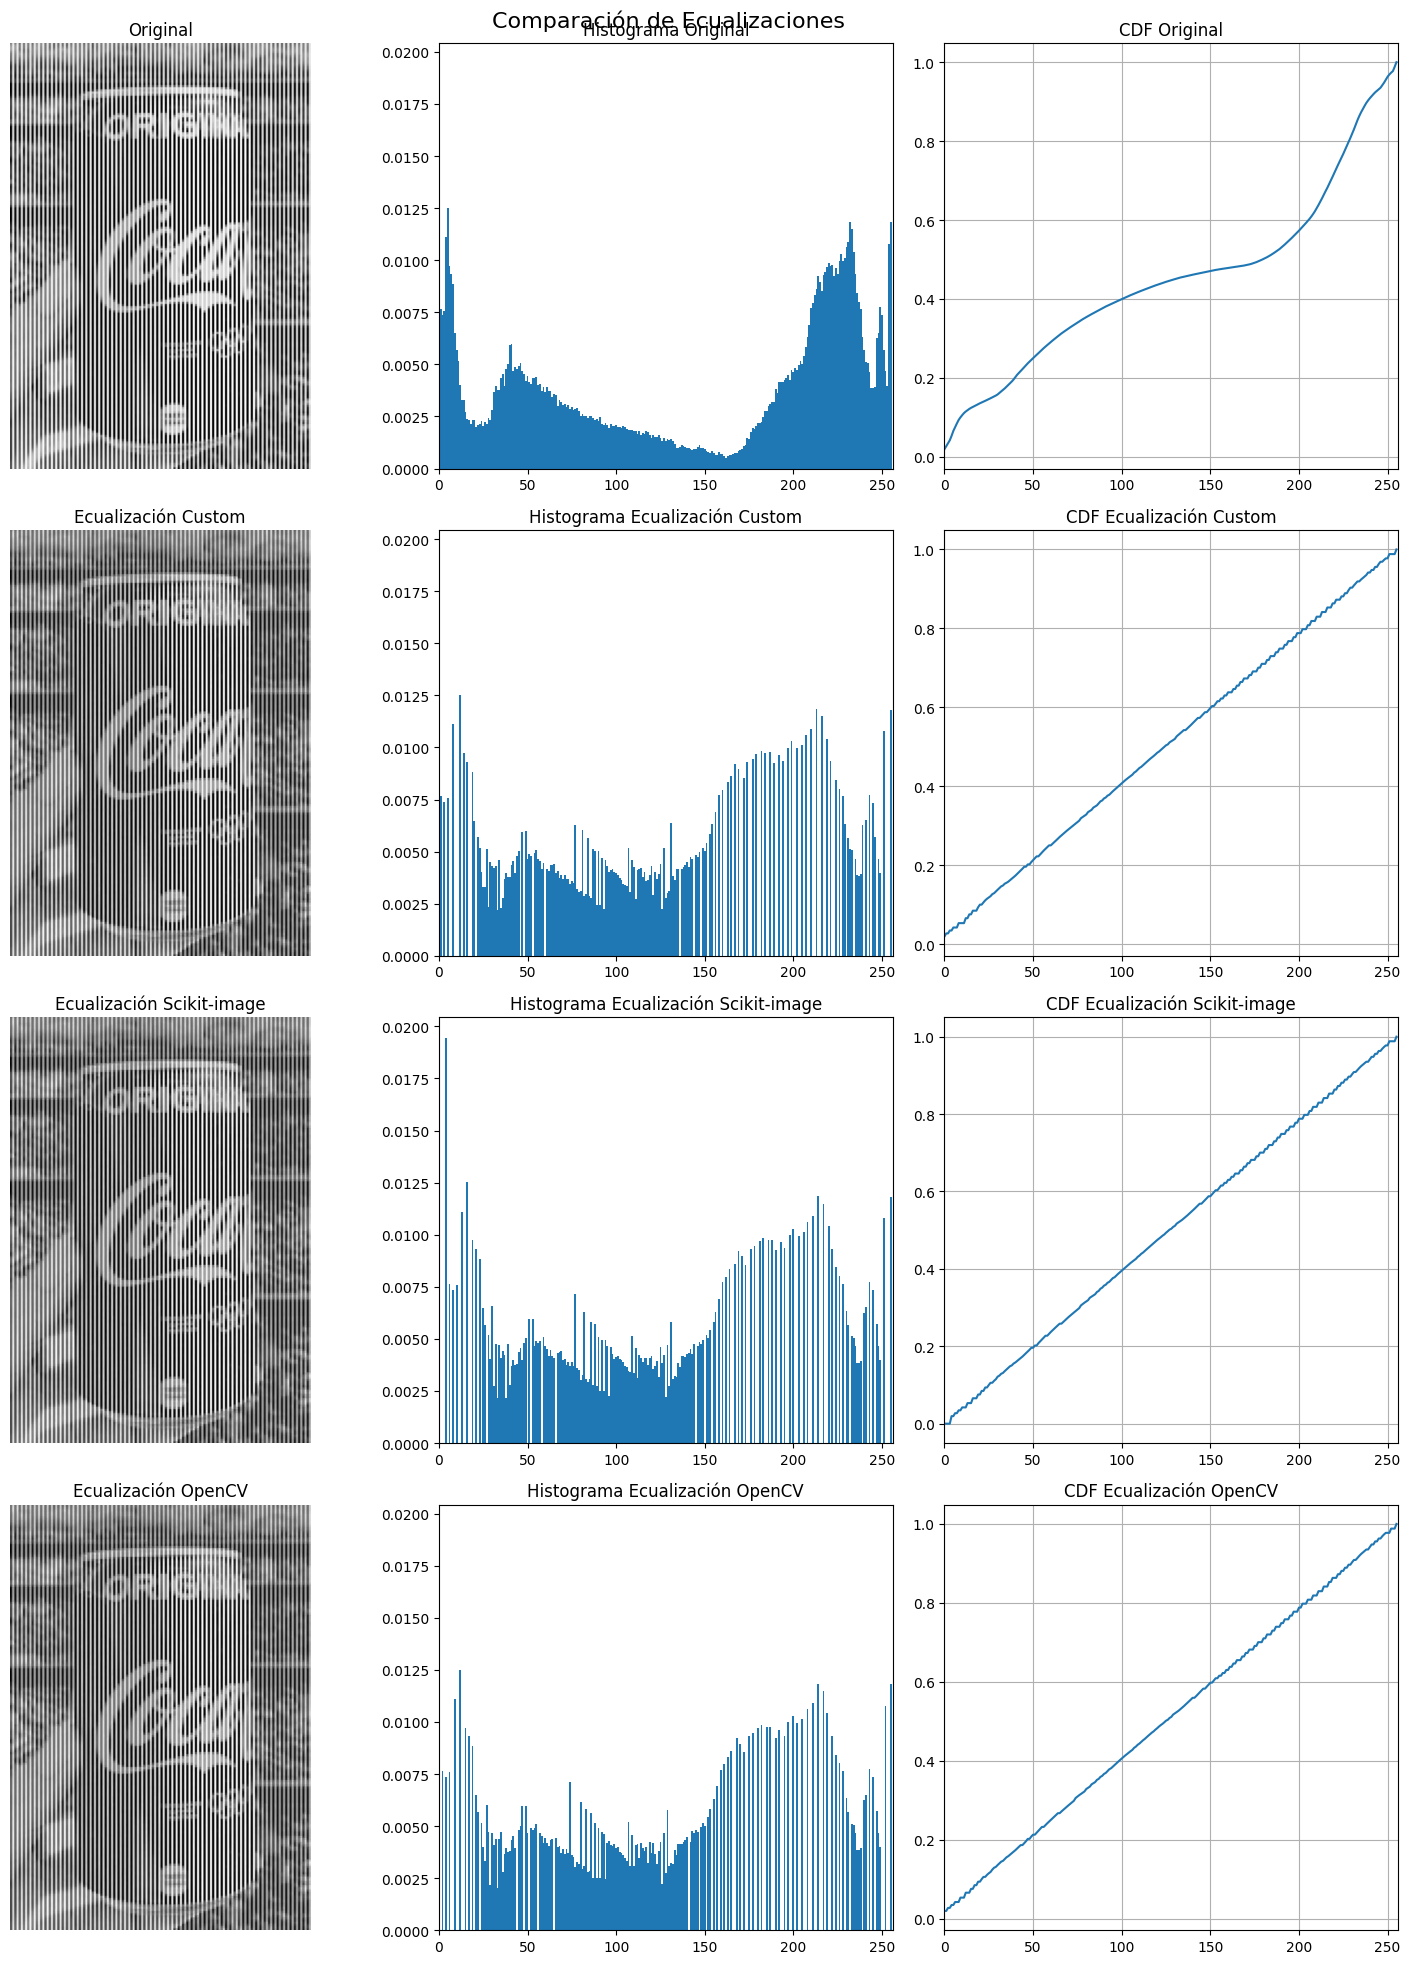

In [10]:
equilize_and_plot_image("./res/coca-cola.jpeg")

¿Son iguales sus resultados con los de la funci´on de Python? Explique por qu´e son iguales o explique por qu´e hay diferencias.

## Ejercicio 2


In [11]:
from scipy import ndimage

In [12]:
def otsu_threshold(image):
    """
    Implementación del algoritmo de Otsu para segmentación binaria.

    Args:
        image: Imagen en escala de grises (numpy array)
    Returns:
        threshold: Valor del umbral óptimo
        binary_image: Imagen binarizada
    """
    hist, bins = np.histogram(image.flatten(), 256, [0, 256])
    hist = hist / hist.sum()  # Normalizar el histograma

    pixel_range = np.arange(256)
    mean_total = np.sum(pixel_range * hist)

    max_variance = 0
    optimal_threshold = 0

    # Calcular la varianza entre clases para cada posible umbral
    weight1 = 0
    mean1 = 0

    for threshold in range(256):
        weight1 += hist[threshold]
        weight2 = 1 - weight1

        if weight1 == 0 or weight2 == 0:
            continue

        mean1 += threshold * hist[threshold]
        mean2 = mean_total - mean1

        mean1_final = mean1 / weight1
        mean2_final = mean2 / weight2

        # Calcular varianza entre clases
        variance = weight1 * weight2 * (mean1_final - mean2_final) ** 2

        if variance > max_variance:
            max_variance = variance
            optimal_threshold = threshold

    binary_image = image > optimal_threshold
    return optimal_threshold, binary_image

In [13]:
def adaptive_threshold(image, window_size=15, C=2):
    """
    Implementación de umbralización adaptativa local.

    Args:
        image: Imagen en escala de grises
        window_size: Tamaño de la ventana para el cálculo local
        C: Constante de ajuste
    Returns:
        binary_image: Imagen binarizada
    """
    # Calcular la media local usando un filtro de promedio
    local_mean = ndimage.uniform_filter(image, size=window_size)

    # La imagen binaria se obtiene comparando cada píxel con su media local menos una constante
    binary_image = image > (local_mean - C)

    return binary_image

In [14]:
def isodata_threshold(image, tolerance=1e-3, max_iter=100):
    """
    Implementación del algoritmo Isodata (Ridler-Calvard).

    Args:
        image: Imagen en escala de grises
        tolerance: Tolerancia para la convergencia
        max_iter: Número máximo de iteraciones
    Returns:
        threshold: Valor del umbral final
        binary_image: Imagen binarizada
    """
    # Inicializar con la media de la imagen
    threshold = np.mean(image)

    for _ in range(max_iter):
        # Separar los píxeles en dos grupos
        foreground = image[image > threshold]
        background = image[image <= threshold]

        # Calcular las medias de los grupos
        mean_fore = np.mean(foreground) if len(foreground) > 0 else threshold
        mean_back = np.mean(background) if len(background) > 0 else threshold

        # Calcular nuevo umbral
        new_threshold = (mean_fore + mean_back) / 2

        # Verificar convergencia
        if abs(new_threshold - threshold) < tolerance:
            break

        threshold = new_threshold

    binary_image = image > threshold
    return threshold, binary_image

In [15]:
def compare_segmentation_methods(image):
    """
    Compara los tres métodos de segmentación.

    Args:
        image: Imagen en escala de grises
    """
    # Aplicar los tres métodos de segmentación
    otsu_thresh, otsu_binary = otsu_threshold(image)
    adaptive_binary = adaptive_threshold(image)
    isodata_thresh, isodata_binary = isodata_threshold(image)

    # Visualizar resultados
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Comparación de Métodos de Segmentación', fontsize=16)

    # Imagen original
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Imagen Original')
    axes[0, 0].axis('off')

    # Método de Otsu
    axes[0, 1].imshow(otsu_binary, cmap='gray')
    axes[0, 1].set_title(f'Otsu (umbral = {otsu_thresh:.1f})')
    axes[0, 1].axis('off')

    # Método adaptativo local
    axes[1, 0].imshow(adaptive_binary, cmap='gray')
    axes[1, 0].set_title('Umbralización Adaptativa Local')
    axes[1, 0].axis('off')

    # Método Isodata
    axes[1, 1].imshow(isodata_binary, cmap='gray')
    axes[1, 1].set_title(f'Isodata (umbral = {isodata_thresh:.1f})')
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

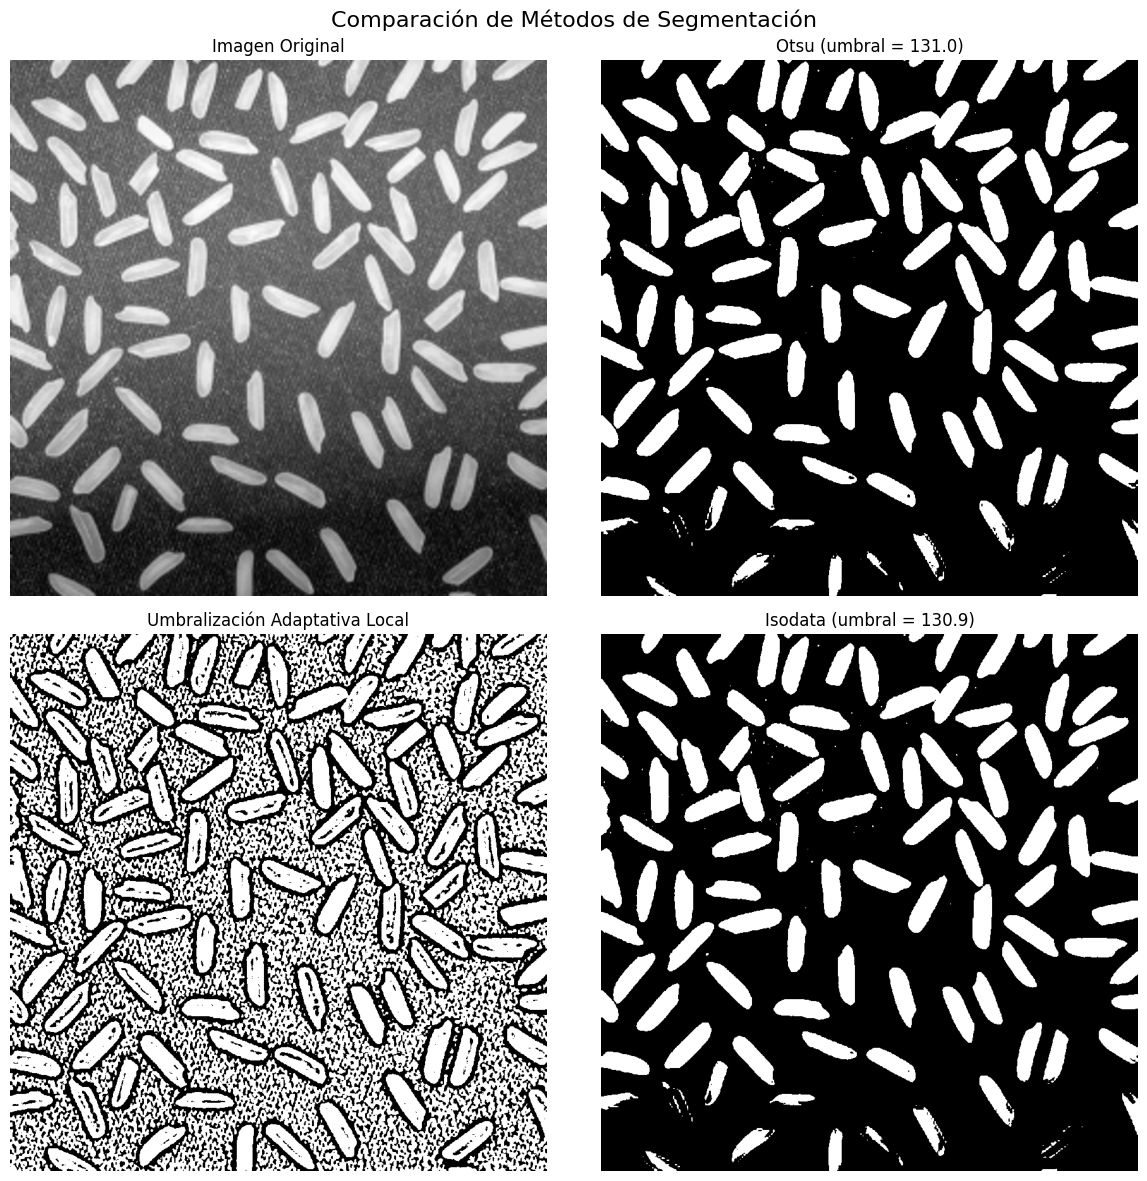

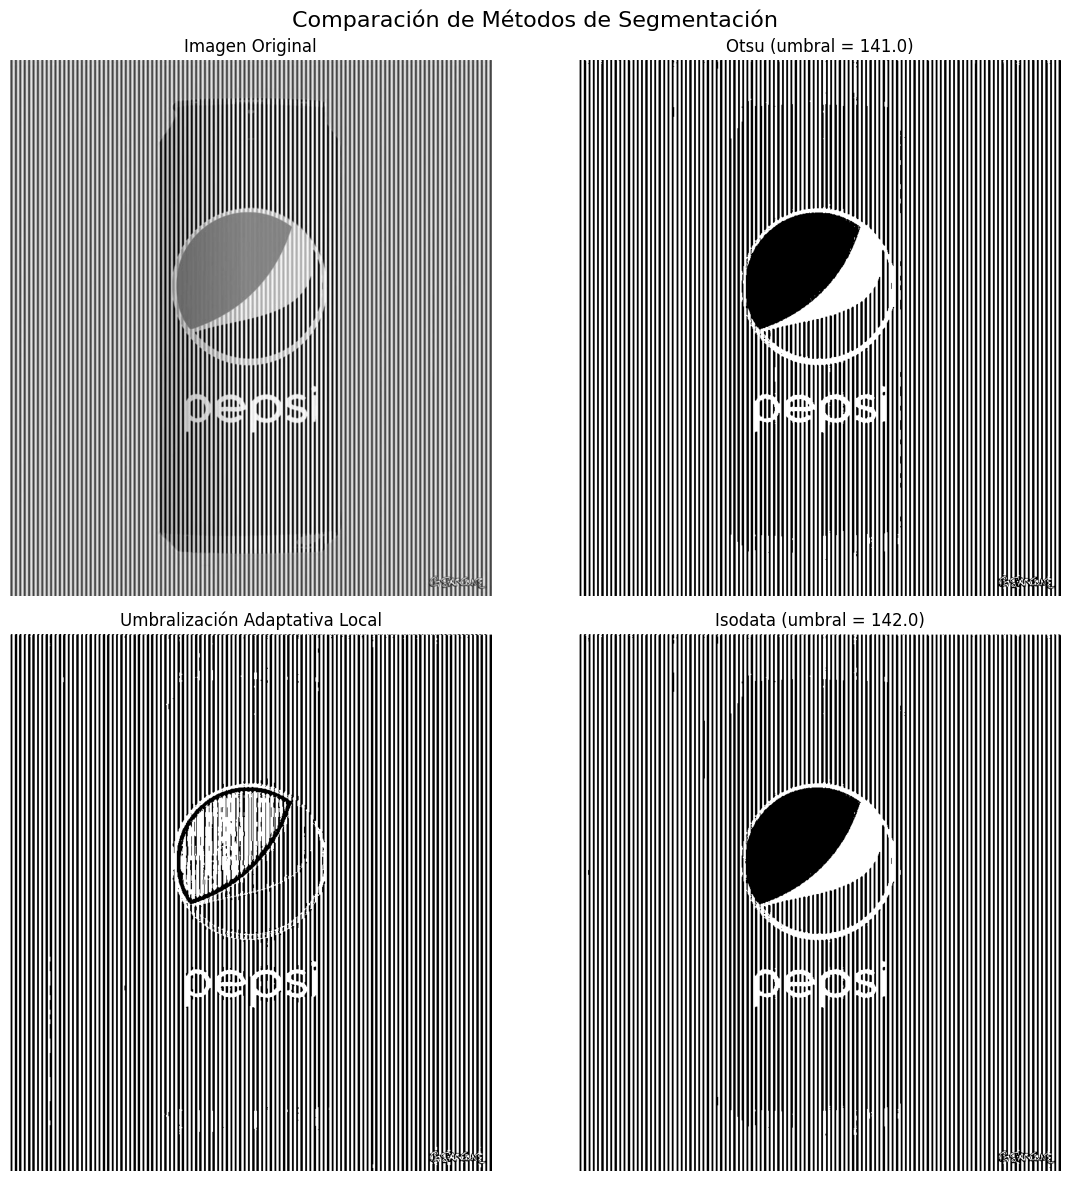

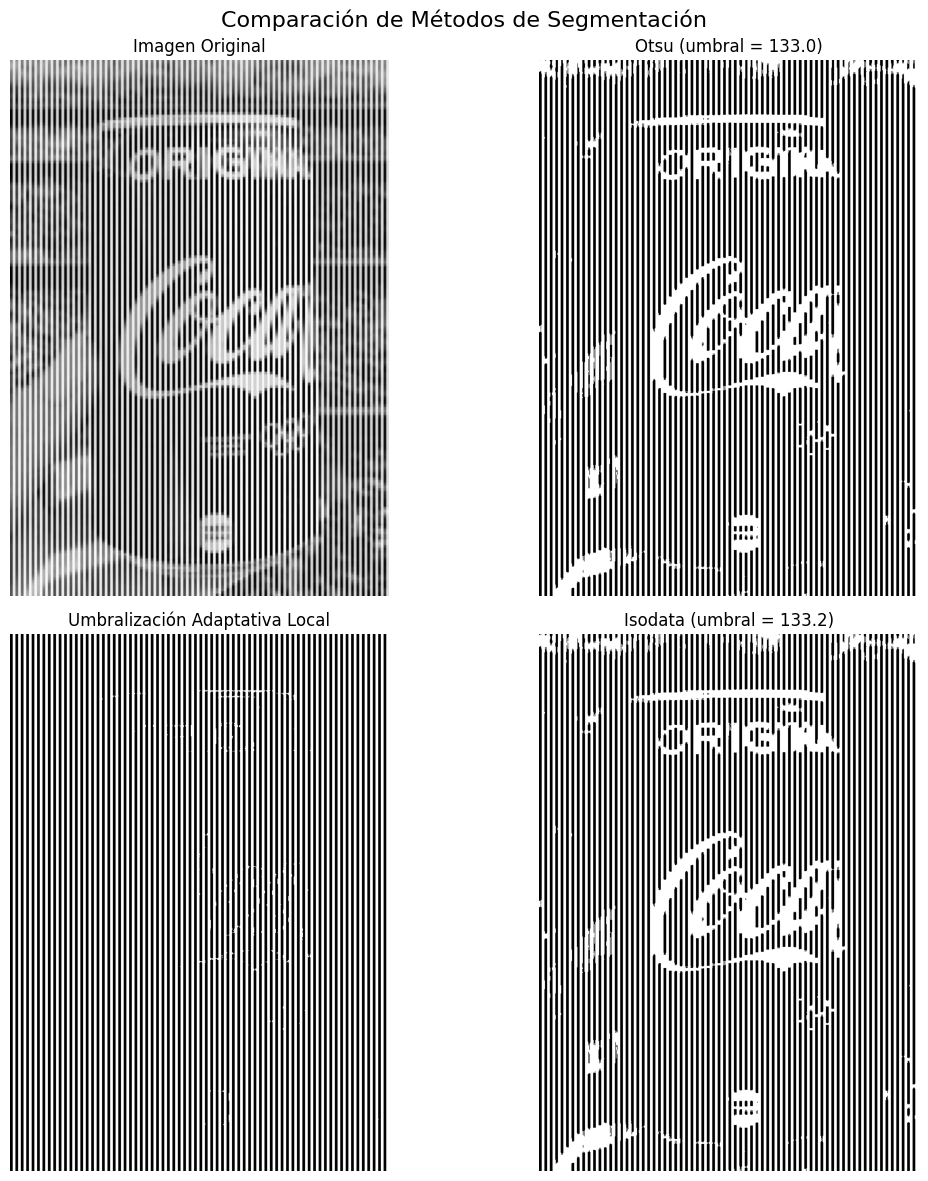

In [18]:
imagenes = [
    './res/rice.jpg',
    './res/pepsi.png',
    './res/coca-cola.jpeg'
]

for img_path in imagenes:
    # Cargar imagen y convertir a escala de grises
    imagen = io.imread(img_path, as_gray=True)

    # Asegurar que la imagen esté en el rango [0, 255]
    if imagen.max() <= 1.0:
        imagen = (imagen * 255).astype(np.uint8)

    compare_segmentation_methods(imagen)